# ReconNN: SparseCNN edition

In this notebook, we are going to train a sparse CNN-based neural network to archieve our TPC reconstruction goal.

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import MinkowskiEngine as ME

import yaml
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm.auto import tqdm, trange

from photonlib import MultiLib, PhotonLib

from pfmatch.io import H5File
from pfmatch.apps import ToyMC
from pfmatch.utils import load_detector_config
from pfmatch.algorithms.hypothesis import FlashHypothesis, MultiFlashHypothesis
from pfmatch.algorithms import PoissonMatchLoss
from contextlib import closing

/sdf/group/mli/zhezhang/conda/envs/ml/lib/python3.10/site-packages/MinkowskiEngine-0.5.4-py3.10-linux-x86_64.egg/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


## Dataset

In this section let's generate the (TPC, PMT) data by using the Icarus detector and the `ToyMC` simulator. You can download the Icarus detector h5 file here. After downloading, please put it under `detectors` folder (you'll need to create that folder first).

### Config the detector

In [2]:
cfg='''
multilib:
    filepath: detectors/plib_2x2.h5
    
photonlib:
    filepath: detectors/plib_icarus.h5
        
Detector: icarus_detector
    
ToyMC:
    TimeAlgo: "random" # random, periodic, same
    TrackAlgo: "random" # random, top-bottom
    PeriodTPC: [-1300.,1300] # in micro-second, [-340-965(drift time),1698.4-340]
    PeriodPMT: [-1000., 1000.] # in micro-second, [-1150, 3450-1150]
    PEVariation: 0.0 # channel-to-channel (PMT-wise) variation in (fake) reco PE amount
    LightYieldVariation: 0.0  # light yield variation per point in QCluster_t
    PosXVariation: 0.0 # total x position variation in cm
    TruncateTPC: 0 # 1=truncate TPC trajectory mimicing readout effect
    NumTracks: 5
    NumpySeed: 1
    NeutrinoTime: 0.

LightPath:
    SegmentSize: 0.5
'''
cfg = yaml.safe_load(cfg)

In [3]:
plib = PhotonLib.load(cfg)

[PhotonLib] loading detectors/plib_icarus.h5
[PhotonLib] file loaded


### Generate the data

If you already generated the data, you can skip this subsection and jump to the load data subsection directly.

In [ ]:
det_cfg = load_detector_config(cfg)
gen = ToyMC(cfg, det_cfg, plib)

[PhotonLib] loading detectors/plib_icarus.h5
[PhotonLib] file loaded


Now we are going to generate 100k data points and save them into a `data/icarus-100k.h5` file.

In [ ]:
os.makedirs('data', exist_ok=True)

bad_cnts = 0
with closing(H5File.open('data/icarus-100k.h5', 'w')) as f:
    for __ in trange(1000):
        data = gen.make_flashmatch_inputs(100)

        out_q = [[q] for q in data.raw_qcluster_v]
        out_f = [[fl] for fl in data.flash_v]
        match_vv = [[(0,0)]] * len(out_q)
        if len(out_q) != len(out_f):
            bad_cnts += 1
            continue
        f.write_many(out_q, out_f, match_vv)
print('bad', bad_cnts)

### Load the data

In [4]:
def load_data(data_root, fnames, plib=None, n_pts=1000, fake=True):

    xyzq_list = []
    pmt_list = []
    dx_list = []
    
    for fname in fnames:
        fullname = os.path.join(data_root, fname)
        print(f'processing {fullname}...')
        f = H5File.open(fullname, 'r')
        
        for idx in trange(n_pts):
            try:
                q_v, f_v, _ = f.read_one(idx, 180)
            except Exception as e:
                print(e)
                continue

            if plib:
                q_v[0].shift_to_center(plib)
            xyzq = q_v[0].qpt_v  # (x, y, z, q)
            if plib is None:
                mu_x = xyzq[:, 0].mean()
                xyzq[:, 0] -= mu_x  # normalization
            if fake:
                pmt = f_v[0].pe_v  # PMT readout
            else:
                pmt = f_v[0].pe_true_v  # PMT readout
            dx = q_v[0].xmin_true - xyzq[:, 0].min().item()  # true dx
    
            xyzq_list.append(xyzq)
            pmt_list.append(pmt)
            dx_list.append(dx)

    return xyzq_list, pmt_list, dx_list

In [5]:
data_root = 'data'
fnames = sorted([n for n in os.listdir(data_root) if n.startswith('icarus')])

In [6]:
xyzq_list, pmt_list, dx_list = load_data(data_root, fnames, plib=plib, n_pts=10000, fake=True)

processing data/icarus-100k.h5...
[H5File] opening data/icarus-100k.h5 in mode r


  0%|          | 0/10000 [00:00<?, ?it/s]

#### Test

In [12]:
xyzq_list[0].shape

torch.Size([1109, 4])

In [13]:
pmt_list[0].shape

torch.Size([180])

In [14]:
dx_list[0]

68.06504821777344

In [15]:
sep = torch.norm(xyzq_list[0][0, :3] - xyzq_list[0][1, :3])

sep

tensor(0.5000)

Check center in x of the first 10 normalized tracks -- should be `-210`

In [16]:
for i in range(10):
    x = xyzq_list[i][:, 0]
    x_c = (x.max() + x.min()) / 2  # this is the correct way
    x_m = x.mean()
    
    print(x_c, x_m)

tensor(-210.0000) tensor(-209.9963)
tensor(-210.) tensor(-210.0092)
tensor(-210.) tensor(-209.9918)
tensor(-210.) tensor(-209.9996)
tensor(-210.) tensor(-210.0238)
tensor(-210.) tensor(-209.9958)
tensor(-210.0000) tensor(-209.9997)
tensor(-210.) tensor(-210.0060)
tensor(-210.) tensor(-209.9686)
tensor(-210.) tensor(-209.9930)


## Forward simulator

Now we are going to setup forward models -- they would be used a bit during our training and post analysis.

In [7]:
def get_dx_ranges(xyzq_list):
    dx_ranges = []
    for i in trange(len(xyzq_list)):
        track_xmin = xyzq_list[i][:, 0].min()
        track_xmax = xyzq_list[i][:, 0].max()
        
        dx_max = forward_model_single._xmax - track_xmax
        dx_min = forward_model_single._xmin - track_xmin

        dx_ranges.append([dx_min, dx_max])
    dx_ranges = torch.tensor(dx_ranges)

    return dx_ranges

In [8]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else torch.device('cpu')

DEVICE

'cuda:0'

In [9]:
plib = plib.to(DEVICE)  # put plib to device

In [10]:
# Create the single forward model
forward_model_single = FlashHypothesis(cfg, plib).to(DEVICE)

# Create the batch forward model
dx_ranges = get_dx_ranges(xyzq_list)
forward_model = MultiFlashHypothesis(plib, dx_ranges).to(DEVICE)

  0%|          | 0/10000 [00:00<?, ?it/s]

### Sanity check

Center in x for the detector -- should be `-210`

In [11]:
(forward_model_single._xmin + forward_model_single._xmax) / 2

-210.0

### Forward model test

In [12]:
def cmp_pmt(idx=0, dx_shift=0, method='clamp'):
    track_i = xyzq_list[idx]
    pmt_i = pmt_list[idx]
    # dx_i = dx_list[idx]
    
    track_i_shifted = torch.clone(track_i)
    track_i_shifted[:, 0] += dx_shift
    if method == 'clamp':
        track_i_shifted[:, 0] = torch.clamp(track_i_shifted[:, 0],
                                            forward_model_single._xmin, forward_model_single._xmax)
    else:
        idx_filtered = (track_i_shifted[:, 0] >= forward_model_single._xmin) * (track_i_shifted[:, 0] <= forward_model_single._xmax)
        track_i_shifted = track_i_shifted[idx_filtered]
    print(f'track size: {track_i_shifted.shape[0]}')
    track_i_shifted = track_i_shifted.to(forward_model_single.plib.device)
    pmt_i_shifted_sim = forward_model_single(track_i_shifted)
    # pmt_i_sim = forward_model(track_i)
    
    fig, ax = plt.subplots(1, 1)
    ax.set(xlabel='pmt channel', ylabel='count')
    ax.set_title(f'track {idx}')
    
    ax.plot(pmt_i, '-', label='groundtruth')
    # ax.plot(pmt_i_sim.detach().numpy(), '-', label='dx = 0')
    ax.plot(pmt_i_shifted_sim.detach().cpu().numpy(), '-', label=f'dx = {dx_shift:.2f}')
    
    # ax.grid()
    ax.legend(loc=0)
    fig.tight_layout()
    
    # fig.savefig('plot.pdf', bbox_inches='tight')
    plt.show()

track size: 1109


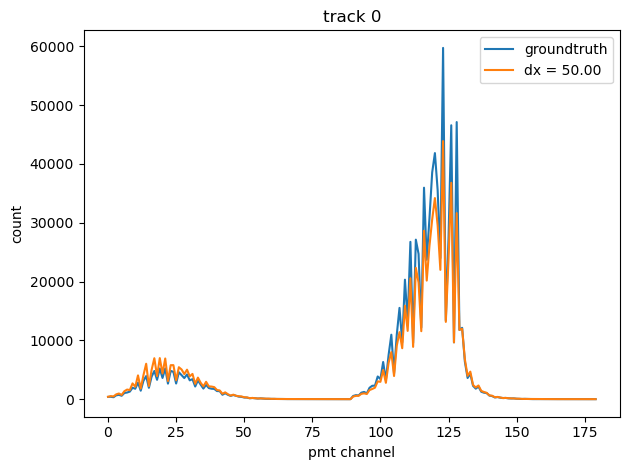

In [13]:
cmp_pmt(0, 50)

track size: 1109


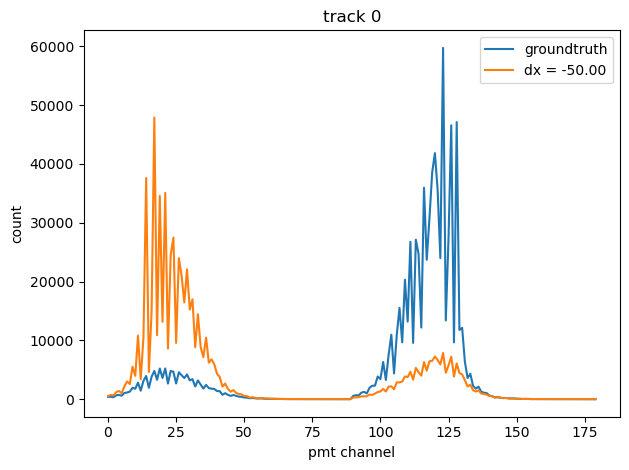

In [14]:
cmp_pmt(0, -50)

track size: 1109


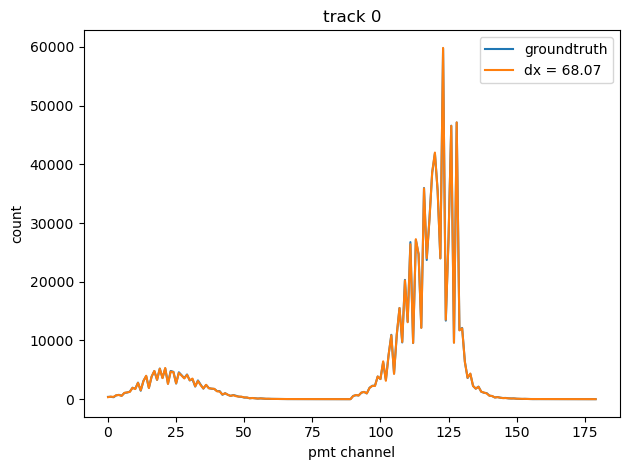

In [15]:
cmp_pmt(0, dx_list[0])

#### Scan loss for random tracks

In [29]:
def scan_loss(indices, n_step=100):
    pmt_sim_list = []
    dx_list = []
    for idx in tqdm(indices):
        dx = torch.linspace(dx_ranges[idx][0], dx_ranges[idx][1], n_step)
        
        batch = []
        sizes = []
        
        xyzq = xyzq_list[idx]
        for i in range(n_step):
            batch.append(xyzq)
            sizes.append(xyzq.shape[0])
        
        batch = torch.vstack(batch)
        sizes = torch.tensor(sizes)
        
        pmt_sim = forward_model.apply(dx.to(DEVICE), batch.to(DEVICE), sizes.to(DEVICE), plib)
        pmt_sim_list.append(pmt_sim)
        dx_list.append(dx)

    criterion = PoissonMatchLoss()
    
    fig, ax = plt.subplots(1, 1)
    ax.set(xlabel='dx (cm)', ylabel='MSE loss')
    
    for i, idx in enumerate(indices):
        dx = dx_list[i]
        pmt_sim = pmt_sim_list[i]
        ax.plot(dx, criterion(pmt_sim, pmt_list[idx].to(DEVICE)).detach().cpu(), '-', label=f'track {idx}')
    
    # ax.grid()
    ax.legend(loc=0)
    fig.tight_layout()
    
    # fig.savefig('plot.pdf', bbox_inches='tight')
    plt.show()

In [30]:
indices = np.random.choice(np.arange(1000), 10, replace=False)

  0%|          | 0/10 [00:00<?, ?it/s]

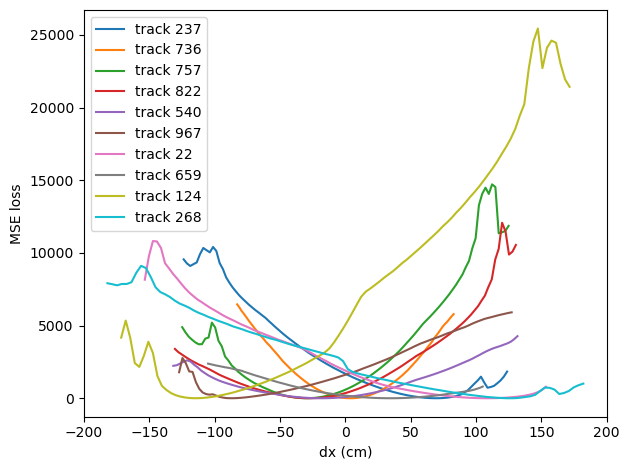

In [31]:
scan_loss(indices)

## Sparse dataset and dataloader

In [43]:
class SparseDataset(Dataset):
    def __init__(self, xyzq_list, pmt_list, dx_list):
        """
        Args:
            xyzq_list (list of tensors): Each tensor has shape (n_i, 4)
            pmt_list: Each tensor has shape (180,)
            dx_list: Each tensor has shape (1,)
        """
        self.xyzq_list = xyzq_list
        self.pmt_list = pmt_list
        self.dx_list = dx_list

    def __len__(self):
        return len(self.dx_list)

    def __getitem__(self, idx):
        input_data = self.xyzq_list[idx]
        coordinates = input_data[:, :3]  # (n_i, 3)
        features = input_data[:, 3:]     # (n_i, 1)
        pmt = self.pmt_list[idx]
        dx = self.dx_list[idx]
        
        return coordinates, features, pmt, dx


def sparse_collate_fn(batch):
    quantization_size = 0.05
    coords_list = []
    feats_list = []
    pmt_list = []
    dx_list = []
    for batch_idx, (coords, feats, pmt, dx) in enumerate(batch):
        # Discretize coordinates
        coords_int = torch.floor(coords / quantization_size).int()
        # Add batch index
        batch_indices = torch.full((coords_int.shape[0], 1), batch_idx, dtype=torch.int)
        batch_indices = batch_indices.to(coords.device)
        coords_batch = torch.cat([batch_indices, coords_int], dim=1)  # (n_i, 4)
        coords_list.append(coords_batch)
        feats_list.append(feats)
        pmt_list.append(pmt)
        dx_list.append(dx)

    # Concatenate all coordinates and features
    all_coords = torch.cat(coords_list, dim=0)  # (total_n, 4)
    all_feats = torch.cat(feats_list, dim=0)    # (total_n, feature_dim)
    all_pmt = torch.vstack(pmt_list)
    all_dx = torch.tensor(dx_list).to(coords_list[0].device)
    
    return {'coordinates': all_coords, 'features': all_feats, 'pmts': all_pmt, 'dxs': all_dx}

### Test

In [44]:
dataset = SparseDataset(xyzq_list, pmt_list, dx_list)

In [45]:
# Create the DataLoader with the custom collate function
batch_size = 1000
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=sparse_collate_fn)

In [46]:
batch = next(iter(dataloader))

In [47]:
batch['coordinates'].shape

torch.Size([1254423, 4])

In [48]:
batch['features'].shape

torch.Size([1254423, 1])

In [49]:
batch['pmts'].shape

torch.Size([1000, 180])

In [50]:
batch['dxs'].shape

torch.Size([1000])

## Network structure

Here you can define your version of sparse CNN-based reconstruction network!

In [51]:
class ReconSparseCNN(ME.MinkowskiNetwork):
    def __init__(self, in_channels=1, out_channels=128, D=3, pmt_count=180):
        super(ReconSparseCNN, self).__init__(D)
        self.conv1 = ME.MinkowskiConvolution(
            in_channels, 64, kernel_size=3, stride=1, dimension=D
        )
        self.bn1 = ME.MinkowskiBatchNorm(64)
        self.relu1 = ME.MinkowskiReLU()

        self.conv2 = ME.MinkowskiConvolution(
            64, out_channels, kernel_size=3, stride=1, dimension=D
        )
        self.bn2 = ME.MinkowskiBatchNorm(out_channels)
        self.relu2 = ME.MinkowskiReLU()

        # Global average pooling to obtain a (1, 128) feature vector
        self.global_pool = ME.MinkowskiGlobalAvgPooling()

        # Subnetwork for B
        self.branch_b = nn.Sequential(
            nn.Linear(pmt_count, 512),
            nn.ReLU(),
            nn.Linear(512, out_channels),
            nn.ReLU()
        )
        
        # Combining both branches
        self.combined_fc = nn.Sequential(
            nn.Linear(2 * out_channels, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, a, b):
        # Part A
        a = self.relu1(self.bn1(self.conv1(a)))
        a = self.relu2(self.bn2(self.conv2(a)))
        out_a = self.global_pool(a).F
        
        # Part B
        out_b = self.branch_b(b)
        
        # Concatenate along feature dimension
        combined = torch.cat((out_a, out_b), dim=1)
        output = self.combined_fc(combined)
        output = 2 * F.sigmoid(output) - 1
        
        return output

### Test

In [53]:
# Instantiate the model
model = ReconSparseCNN(in_channels=1, out_channels=128, D=3)

# Iterate over the DataLoader
for batch in dataloader:
    # Create SparseTensor
    sparse_input = ME.SparseTensor(features=batch['features'], coordinates=batch['coordinates'])

    # Forward pass
    output = model(sparse_input, batch['pmts'])

    print("Output feature vector shape:", output.shape)
    # Perform your training steps here (e.g., loss computation, backpropagation)
    # For demonstration, we'll process one batch
    break

Output feature vector shape: torch.Size([1000, 1])


In [52]:
def count_parameters(module):
    return sum(p.numel() for p in module.parameters())

In [54]:
count_parameters(model)

418689

In [55]:
count_parameters(model.branch_b)

158336

## Training!

### Feature normalization

Here we perform the feature normalization for the `q` part of the `(x, y, z, q)` node in the TPC track. `(x, y, z)` is treated as coordinates here so no need to normalize, it will go through quantization process instead.

In [56]:
XYZQ = torch.concat(xyzq_list, dim=0)
PMT = torch.stack(pmt_list)
dX = torch.tensor(dx_list, dtype=XYZQ.dtype)

In [57]:
XYZQ.shape, PMT.shape, dX.shape

(torch.Size([12748908, 4]), torch.Size([10000, 180]), torch.Size([10000]))

In [58]:
Q_mu = XYZQ[:, 3].mean()
Q_std = XYZQ[:, 3].std()
PMT_mu = PMT.mean(dim=0)
PMT_std = PMT.std(dim=0)

In [59]:
Q_mu, Q_std

(tensor(26389.5801), tensor(428.9499))

In [60]:
PMT_mu[:4], PMT_std[:4]

(tensor([ 889.4356,  870.9064, 1167.6302, 1527.8296]),
 tensor([3626.9465, 3141.2056, 4427.1680, 5026.2666]))

### Pre-load to GPU

Then we preload the data to GPU for higher GPU utilization -- if you are using CPU then this step can be skipped.

In [61]:
xyzq_list_gpu = []
pmt_list_gpu = []
dx_list_gpu = []
for i in tqdm(range(len(xyzq_list))):
    xyzq = xyzq_list[i]
    pmt = pmt_list[i]
    dx = dx_list[i]

    # Normalization
    xyzq[:, 3] = (xyzq[:, 3] - Q_mu) / Q_std
    pmt = (pmt - PMT_mu) / PMT_std

    # Preload to GPU
    xyzq_list_gpu.append(xyzq.to(DEVICE))
    pmt_list_gpu.append(pmt.to(DEVICE))
    dx_list_gpu.append(torch.tensor(dx, dtype=pmt.dtype).to(DEVICE))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [72]:
Q_mu_gpu = Q_mu.to(DEVICE)
Q_std_gpu = Q_std.to(DEVICE)
PMT_mu_gpu = PMT_mu.to(DEVICE)
PMT_std_gpu = PMT_std.to(DEVICE)

#### Test

In [62]:
xyzq_list_gpu[0].shape

torch.Size([1109, 4])

In [63]:
pmt_list_gpu[0].shape

torch.Size([180])

In [64]:
dx_list_gpu[0]

tensor(68.0650, device='cuda:0')

In [65]:
dataset = SparseDataset(xyzq_list_gpu, pmt_list_gpu, dx_list_gpu)

In [66]:
# Create the DataLoader with the custom collate function
batch_size = 1000
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=sparse_collate_fn)

In [67]:
batch = next(iter(dataloader))

In [68]:
batch['coordinates'].shape

torch.Size([1254423, 4])

In [69]:
batch['features'].shape

torch.Size([1254423, 1])

In [70]:
batch['pmts'].shape

torch.Size([1000, 180])

In [71]:
batch['dxs'].shape

torch.Size([1000])

### Train the model w/ labels!

Training params:

In [73]:
num_epochs = 500
batch_size = 1000
lr = 1e-3

save_filename = 'models/recon_sparse_cnn.pt'
reload_filename = None

Make the training/validation/test dataloaders

In [84]:
os.makedirs('models', exist_ok=True)

dataset = SparseDataset(xyzq_list_gpu, pmt_list_gpu, dx_list_gpu)

# Split the dataset into training and test sets
train_size = int(0.6 * len(dataset))  # 20% of dataset for training
vali_size = int(0.2 * len(dataset))  # The rest for testing
test_size = len(dataset) - train_size - vali_size # The rest for testing
train_dataset, vali_dataset, test_dataset = random_split(dataset, [train_size, vali_size, test_size])

# Create DataLoaders for both the training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              collate_fn=sparse_collate_fn, shuffle=True)
vali_dataloader = DataLoader(vali_dataset, batch_size=batch_size,
                             collate_fn=sparse_collate_fn, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             collate_fn=sparse_collate_fn, shuffle=False)

Initialize the recon network

In [76]:
# Initialize the network, loss function, and optimizer as before
model = ReconSparseCNN(in_channels=1, out_channels=128, D=3).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999), weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

if reload_filename:
    model.load_state_dict(torch.load(reload_filename, map_location=DEVICE))

Train it!

In [ ]:
# Training loop
train_loss = []
vali_loss = []
best_loss = None

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, batch in enumerate(train_dataloader):
        sparse_input = ME.SparseTensor(features=batch['features'], coordinates=batch['coordinates'])
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        _dx = model(sparse_input, batch['pmts']).flatten()
        dx = _dx * (forward_model_single._xmax - forward_model_single._xmin) / 2
        loss = criterion(dx.flatten(), batch['dxs'])

        # print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataloader)}], '
        #       f'Training Loss: {loss:.4f}')
        
        loss.backward()
        optimizer.step()
        # scheduler.step()  # Adjust the learning rate if using a scheduler
        
        running_loss += loss.item()
        
        if not (i % 100):  # Every 100 batches
            # Evaluate on validation dataset
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                val_losses = []
                
                for batch_val in vali_dataloader:
                    sparse_input_val = ME.SparseTensor(
                        features=batch_val['features'],
                        coordinates=batch_val['coordinates']
                    )
                    
                    _dx = model(sparse_input_val, batch_val['pmts']).flatten()
                    dx = _dx * (forward_model_single._xmax - forward_model_single._xmin) / 2
                    loss_val = criterion(dx.flatten(), batch_val['dxs'])
                    val_losses.append(loss_val.item())
                    # break  # just do one loop
                
                avg_val_loss = sum(val_losses) / len(val_losses)

            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], '
                  f'Validation Loss: {avg_val_loss:.4f}')
            vali_loss.append(avg_val_loss)
            model.train()  # Switch back to training mode

            if save_filename:
                if (best_loss is None) or (avg_val_loss < best_loss):
                    print('Model on disk updated')
                    best_loss = avg_val_loss
                    torch.save(model.state_dict(), save_filename)
            
    # Print epoch loss
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")
    # print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, LR: {scheduler.get_last_lr()[0]}")
    train_loss.append(epoch_loss)

print("Training complete.")

## Post analysis

### Check the loss curves

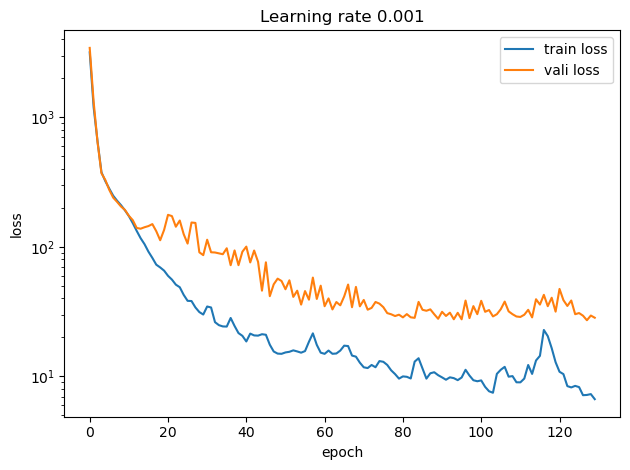

In [78]:
fig, ax = plt.subplots(1, 1)
ax.set(xlabel='epoch', ylabel='loss')
ax.set_title(f'Learning rate {lr}')
# ax.set_ylim(3000, 4000)
# ax.set_xlim(100, 500)
ax.set_yscale('log')

ax.plot(train_loss, label='train loss')
ax.plot(vali_loss, label='vali loss')

# ax.grid()
ax.legend(loc=0)
fig.tight_layout()

# fig.savefig('plot.pdf', bbox_inches='tight')
plt.show()

### Check model performance on test dataset

#### Load the model

In [79]:
model_label = ReconSparseCNN(in_channels=1, out_channels=128, D=3).to(DEVICE)
model_label.load_state_dict(torch.load(save_filename, map_location=DEVICE))
model_label.eval()

ReconSparseCNN(
  (conv1): MinkowskiConvolution(in=1, out=64, kernel_size=[3, 3, 3], stride=[1, 1, 1], dilation=[1, 1, 1])
  (bn1): MinkowskiBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): MinkowskiReLU()
  (conv2): MinkowskiConvolution(in=64, out=128, kernel_size=[3, 3, 3], stride=[1, 1, 1], dilation=[1, 1, 1])
  (bn2): MinkowskiBatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): MinkowskiReLU()
  (global_pool): MinkowskiGlobalAvgPooling(mode=PoolingMode.GLOBAL_AVG_POOLING_PYTORCH_INDEX)
  (branch_b): Sequential(
    (0): Linear(in_features=180, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
  )
  (combined_fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True

#### Predict on test dataset (all in one batch)

In [81]:
def get_dx_loss(dataloader, model):
    
    loss_dx_list = []
    
    for batch in tqdm(dataloader):
        sparse_input = ME.SparseTensor(features=batch['features'], coordinates=batch['coordinates'])
        _dx = model(sparse_input, batch['pmts'])
        dx = _dx * (forward_model_single._xmax - forward_model_single._xmin) / 2
        
        loss_dx = (dx.flatten() - batch['dxs']) ** 2
        loss_dx_list.append(loss_dx.detach().cpu())
        
    return torch.hstack(loss_dx_list)

In [85]:
loss_dx_label = get_dx_loss(test_dataloader, model_label)

  0%|          | 0/2 [00:00<?, ?it/s]

In [87]:
def plot_rms_dx_dist(loss_dx, thres_rms=1e3, save=None):
    
    rms_dx = torch.sqrt(loss_dx)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.set(xlabel='rms(dx)', ylabel='count')
    
    # ax.set_yscale('log')
    
    p = (rms_dx < thres_rms).sum() / len(rms_dx) * 100
    ax.hist(rms_dx[rms_dx < thres_rms], 100, label=f'label ({p:.2f}%)', alpha=0.8)
    
    # ax.grid()
    ax.legend(loc=0)
    fig.tight_layout()
    
    if save:
        fig.savefig(save, dpi=200, bbox_inches='tight')
        
    plt.show()

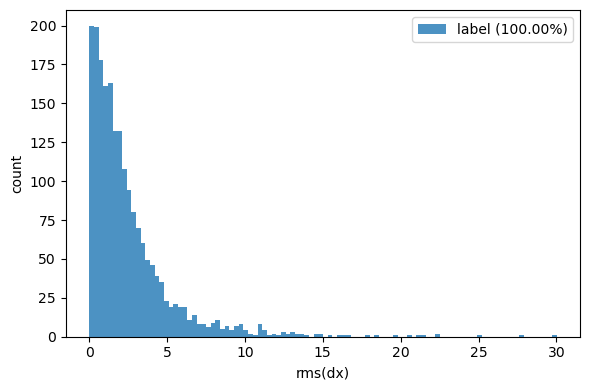

In [90]:
os.makedirs('pics', exist_ok=True)

plot_rms_dx_dist(loss_dx_label, save='pics/rms_dx_dist.png')

## Backlogs